In [61]:
import numpy as np
import torch
import networkx as nx

### Creating Simple Graph

In [3]:
H = nx.DiGraph()

In [4]:
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),
  (1, {"color": "yellow", "size": 400}),
  (2, {"color": "orange", "size": 150}),
  (3, {"color": "red", "size": 600})
])

In [7]:
for node in H.nodes(data=True):
  print(node)

(0, {'color': 'blue', 'size': 250})
(1, {'color': 'yellow', 'size': 400})
(2, {'color': 'orange', 'size': 150})
(3, {'color': 'red', 'size': 600})


In [8]:
H.add_edges_from([
  (0, 1),
  (1, 2),
  (1, 0),
  (1, 3),
  (2, 3),
  (3,0)
])

[(0, 1), (1, 2), (1, 0), (1, 3), (2, 3), (3, 0)]


In [12]:
H.nodes()

NodeView((0, 1, 2, 3))

In [10]:
H.edges()

OutEdgeView([(0, 1), (1, 2), (1, 0), (1, 3), (2, 3), (3, 0)])

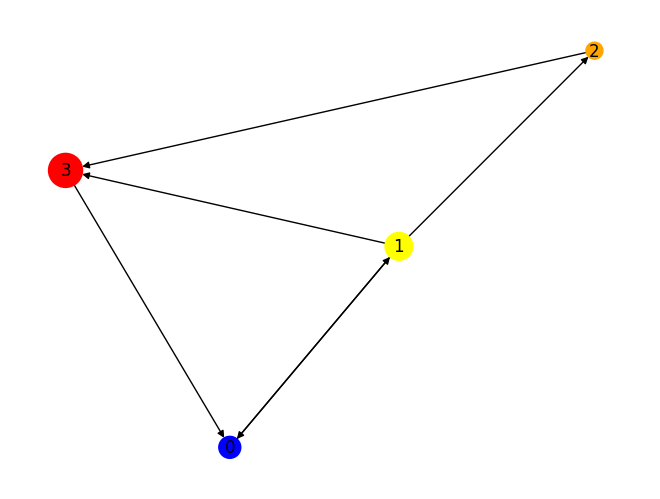

In [14]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)

node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

In [15]:
G = H.to_undirected()
print(G.edges())

[(0, 1), (0, 3), (1, 2), (1, 3), (2, 3)]


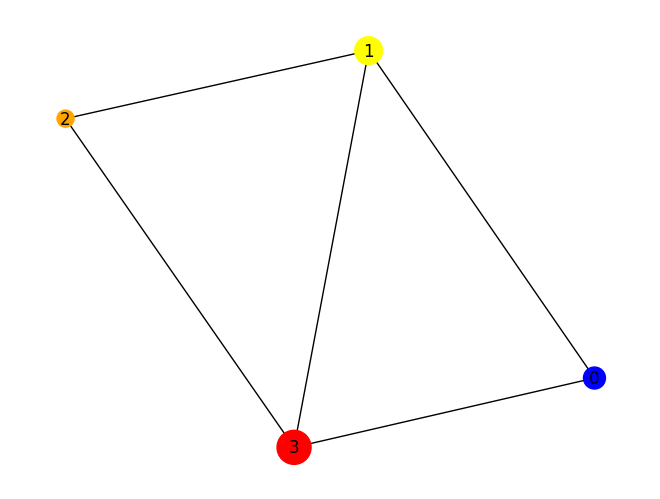

In [17]:
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

### Node Classification with Graph Neural Networks

In [52]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [53]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

### Exploring Data


In [54]:
print('Dataset: ', dataset)
print()
print('Number of graphs: ', len(dataset))
print('Number of features: ', dataset.num_features)
print('Number of classes: ', dataset.num_classes)

Dataset:  Cora()

Number of graphs:  1
Number of features:  1433
Number of classes:  7


In [62]:
data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [63]:
print("Number of Nodes: ", data.num_nodes)
print("Number of Edges: ", data.num_edges)

Number of Nodes:  2708
Number of Edges:  10556


In [64]:
print("Number of Nodes: ", data.has_isolated_nodes())
print("Number of Nodes: ", data.has_self_loops())
print("Number of Nodes: ", data.is_undirected())

Number of Nodes:  False
Number of Nodes:  False
Number of Nodes:  True


In [65]:
edge_index = data.edge_index
print(type(edge_index))

<class 'torch.Tensor'>


In [66]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
print(edge_index)

(2, 10556)
[[   0    0    0 ... 2707 2707 2707]
 [ 633 1862 2582 ...  598 1473 2706]]


In [67]:
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

### Training a Graph Neural Network (GNN)

In [68]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [69]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [70]:
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


### Visualizing Untrained GCN network
7-dimensional node embeddings onto a 2D plane.



In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [72]:
model = GCN(hidden_channels=16)
model.eval()

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

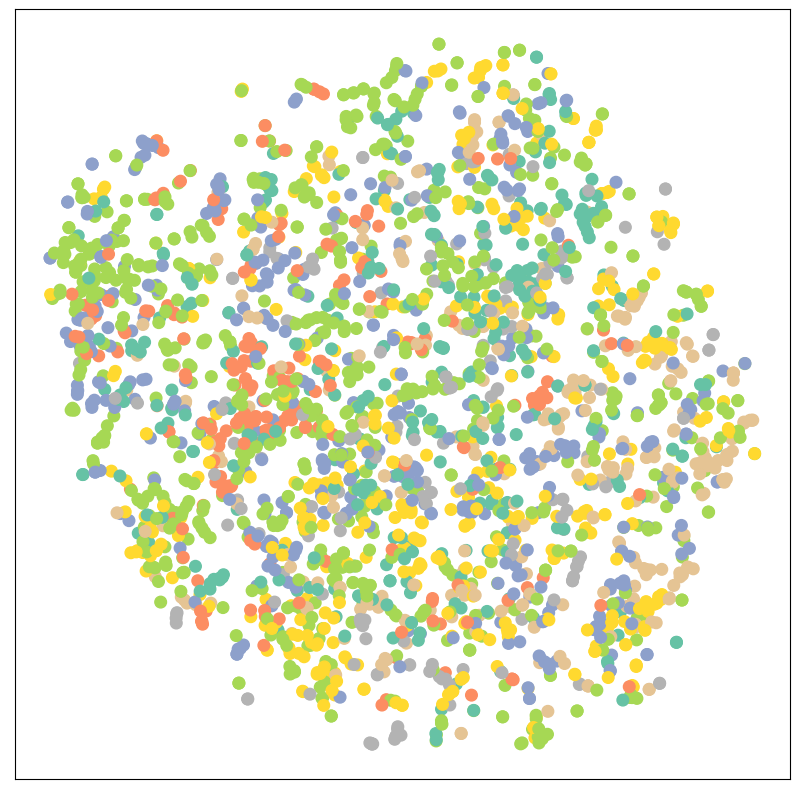

In [73]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [74]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [75]:
def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

In [76]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

In [77]:
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [78]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


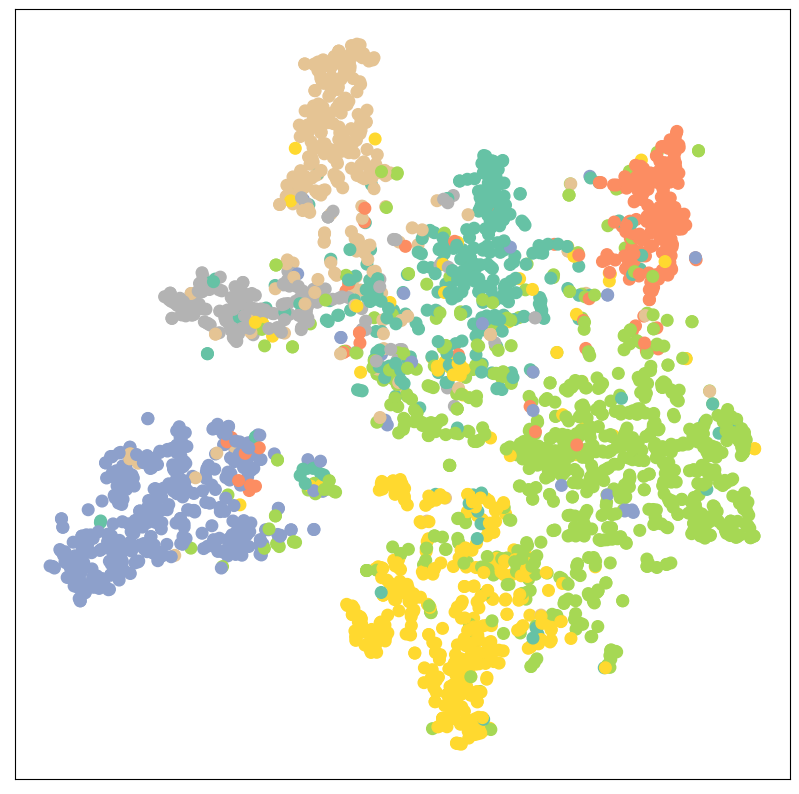

In [79]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### GNN Explainer

In [99]:
from torch_geometric.nn import GNNExplainer

In [100]:
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200)

/home/abdulrehman/anaconda3/envs/gnn_env/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'nn.models.GNNExplainer' is deprecated, use 'explain.Explainer' with 'explain.algorithm.GNNExplainer' instead
  warnings.warn(out)


In [101]:
node_idx = 30
node_feature_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

In [103]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)

AttributeError: 'GNNExplainer_' object has no attribute 'visualize_subgraph'

In [98]:
dir(explainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_convert_output',
 '_explainer',
 'coeffs',
 'conversion_node_mask_type',
 'conversion_return_type',
 'explain_graph',
 'explain_node',
 'get_initial_prediction',
 'model']